# Imports

In [7]:
import torch
import gpytorch
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

from ipywidgets import interact
import glob
import numpy as np
from scripts.helper import open_img_as_array
from skimage.measure import label

PATH_TO_DATA = './CloC/'

IMG_SIZE = (100, 200)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Helper functions

In [2]:
def clear_small_groups(img, min_size=100):
    img = img.copy()
    cimg = img.copy()
    cimg[img < img.max()] = 0
    cimg[img == img.max()] = 1
    limg = label(cimg, background=1)
    unique, counts = np.unique(limg, return_counts=True)
    for i, count in zip(unique, counts):
        if count < min_size:
            img[limg == i] = 0
    return img

# GPModel class

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, RBF_lengthscale_constraint=None, Periodic_lengthscale_constraint=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ZeroMean()
        self.RBF = gpytorch.kernels.RBFKernel(
            ard_num_dims=3, lengthscale_constraint=RBF_lengthscale_constraint)
        self.Periodic = gpytorch.kernels.PeriodicKernel(
            ard_num_dims=3, lengthscale_constraint=Periodic_lengthscale_constraint)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            self.RBF) + gpytorch.kernels.ScaleKernel(self.Periodic)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def start_training(self, train_x, train_y, num_iter=100, need_plot=True):
        self.train()
        self.likelihood.train()
        # Includes GaussianLikelihood parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        my_loss = gpytorch.mlls.ExactMarginalLogLikelihood(
            self.likelihood, self)

        history = {"loss": [],
                   "lengthscale": [],
                   "noise": []}

        for _ in tqdm(range(num_iter), desc='Training'):
            optimizer.zero_grad()
            output = self(train_x)
            loss = -my_loss(output, train_y)
            loss.backward()
            history["loss"].append(loss.item())
            # lengthscale = self.covar_module.base_kernel.lengthscale.item()
            # history["lengthscale"].append(lengthscale)
            # history["noise"].append(self.likelihood.noise.item())
            optimizer.step()

        if need_plot:
            plt.figure(figsize=(10, 5))
            plt.plot(history["loss"])
            plt.title(f'Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()

    def predict(self, data, num_samples=16, need_plot=True):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            sampled_preds = self(data.to(device)).rsample(
                sample_shape=torch.Size((num_samples,)))

        if need_plot:
            n = int(num_samples ** 0.5)
            _, axs = plt.subplots(n, n, figsize=(20, 10))
            plt.suptitle(f'Samples')
            for i in range(n):
                for j in range(n):
                    axs[i, j].imshow(
                        sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), cmap='PuOr')
                    axs[i, j].contour(
                        sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), levels=0, colors='k')
                    axs[i, j].axis('off')
            plt.show()

        return sampled_preds

# Generation of the dataset

In [4]:
def default_train():
    # Train set and test set initialization
    dx, dy = 1 / IMG_SIZE[0], 1 / IMG_SIZE[1]
    xv, yv = torch.meshgrid(torch.linspace(0, 1-dx, IMG_SIZE[0]), torch.linspace(0, 1-dy, IMG_SIZE[1]), indexing="ij")
    x_test = torch.cat((
        xv.contiguous().view(xv.numel(), 1),
        yv.contiguous().view(yv.numel(), 1)),
        dim=1)

    x_train = torch.cat((x_test[:5*IMG_SIZE[1], :], x_test[-5*IMG_SIZE[1]:, :]), 0)
    x_train = map_to_cylinder(x_train)
    x_test = map_to_cylinder(x_test)
    y_train = torch.cat((torch.ones(5*IMG_SIZE[1]), -torch.ones(5*IMG_SIZE[1])))

    # Model initialization and training
    rbf_lengthscale_right = Interval(0.01, 0.32)
    periodic_lengthscale_right = Interval(0.01, 0.15)

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(x_train, y_train, likelihood, RBF_lengthscale_constraint=rbf_lengthscale_right, Periodic_lengthscale_constraint=periodic_lengthscale_right)

    model = model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    model.start_training(x_train, y_train, num_iter=100, need_plot=True)
    
    return model, x_test


## Sampling

### Prediction

Training: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


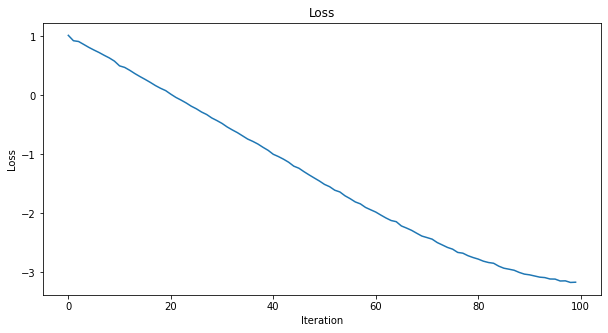

In [12]:
model, x_test = default_train()

In [6]:
samples = model.predict(x_test.to(device), num_samples=1000, need_plot=False)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

### Saving results

In [ ]:
os.makedirs(PATH_TO_DATA, exist_ok=True)

for i, sample in enumerate(samples):
    plt.imshow(sample * 0, cmap='gray_r')
    plt.contour(sample, levels=0, colors='k')
    plt.axis('off')
    plt.savefig(PATH_TO_DATA + f'/{i+1:05}.png', bbox_inches='tight', pad_inches=0, facecolor='white')
    # don't display image
    # plt.clf()
    break


# Splitting, clearing and getting targets

In [7]:
# def split_map(path, x_parts, scale_coef, color, p, need_plot=False):
#     img = open_img_as_array(path) if isinstance(path, str) else path
#     splitted = img.copy()
#     width, height = img.shape
#     sq_size = width // x_parts
#     delta = int(scale_coef * sq_size / 2)
    
#     # for x in range(sq_size // 2, width, sq_size):
#     #     for y in range(sq_size // 2, height, sq_size):
#     #         splitted[x-delta:x+delta, y-delta:y+delta] = color

#     # the loop above colors the uniform squares with the same color
#     # now i want to do the same but shift all squares by a random unit vector

#     for x in range(sq_size // 2, width, sq_size):
#         for y in range(sq_size // 2, height, sq_size): 
#             # do the next with probability p:
#             shift = 0 * np.random.randint(-delta // 2, delta // 2, 2)
#             splitted[x-delta:x+delta, y-delta:y+delta] = color

#     # black_pixs = np.sum(splitted < imax)
#     # cleared = clear_small_groups(splitted, min_size)
#     # print(np.unique(cleared))
#     # percent_of_cleared = 100 * (1 - np.sum(cleared < imax) / black_pixs)
#     # print(f'percent_of_cleared = {percent_of_cleared:.2f}%')
#     # if need_plot:
#     #     plt.subplot(1, 3, 3)
#     #     plt.imshow(cleared, cmap='gray')
#     #     plt.title(f'After clearing {percent_of_cleared:.2f}% of black pixels')

#     return splitted

def split_map(path, x_parts, scale_coef, color, need_plot=False):
    img = open_img_as_array(path) if isinstance(path, str) else path
    width, height = img.shape
    sq_size = width // x_parts
    splitted = img.copy()
    delta = int(scale_coef * sq_size / 2)
    for x in range(sq_size // 2, width, sq_size):
        for y in range(sq_size // 2, height, sq_size): 
            splitted[x-delta:x+delta, y-delta:y+delta] = color
    return splitted

In [13]:
@interact(i=(0, len(samples) - 1), x_parts=(2, 10), scale_coef=(0.5, 1, 0.05), color=(0, 1, 0.05))
def real_time(i=0, x_parts=5, scale_coef=0.85, color=0):
    img = samples[i]
    # normalize to [-1, 1]
    img = (img - img.min()) / (img.max() - img.min()) * 2 - 1
    # print(img.min(), img.max())
    # # img = (img - img.min()) / (img.max() - img.min()) * 255
    sign = img > 0
    # values of sign are True or False
    # for every True value if at least one of its neighbours is False then it is a border
    # find all borders and make a new array with the same shape as img where borders are True and others are False
    original = np.zeros_like(img)
    for x in range(1, img.shape[0]-1):
        for y in range(1, img.shape[1]-1):
            original[x, y] = sign[x, y] and (not sign[x-1, y] or not sign[x+1, y] or not sign[x, y-1] or not sign[x, y+1])
    splitted = 1 - split_map(path=original, x_parts=x_parts, scale_coef=scale_coef, color=color, need_plot=False)
    plt.figure(figsize=(20, 5))
    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(1 - original, cmap='gray')
    plt.title('Original')
    # sign distribution
    plt.subplot(1, 3, 2)
    plt.imshow(sign, cmap='gray')
    plt.title('Sign distribution')
    # split map
    plt.subplot(1, 3, 3)
    plt.imshow(splitted, cmap='gray')
    plt.title('Splitted')

interactive(children=(IntSlider(value=0, description='i', max=999), IntSlider(value=5, description='x_parts', …

# Downscaling

In [ ]:
def downscale_map(img, sq_size):
    img = np.array(img)
    width, height = img.shape
    x_parts = width // sq_size
    y_parts = height // sq_size
    downsampled = np.zeros((x_parts, y_parts))
    for x in range(x_parts):
        for y in range(y_parts):
            downsampled[x, y] = (img[x*sq_size:(x+1)*sq_size, y*sq_size:(y+1)*sq_size] < img.max()).sum == 0
    return downsampled

@interact(i=(0, len(samples)-1) , sq_size=(1, 25))
def _(i, sq_size=5):
    img = samples[i] > 0
    downsampled = downscale_map(img, sq_size)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original shape = {img.shape}')
    plt.subplot(1, 2, 2)
    plt.imshow(downsampled, cmap='gray')
    plt.title(f'Downsampled shape = {downsampled.shape}')


# Postprocessing GP predictions

In [1]:
from scripts.helpgauss import default_train
from scripts.helper import prepare_gpr_results
import torch
import matplotlib.pyplot as plt
import numpy as np
# import clear_output
from IPython.display import clear_output
from ipywidgets import interact

IMG_SIZE = (50, 100)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


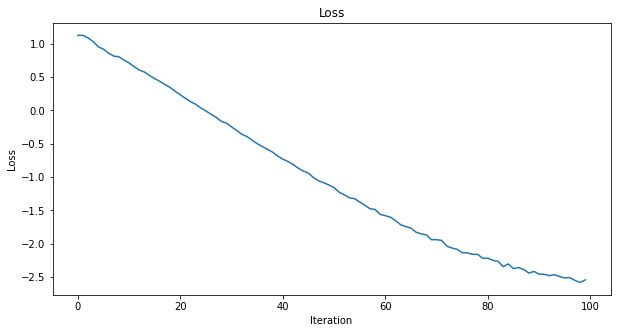

In [2]:
model, x_test = default_train(rbf_right=0.3)

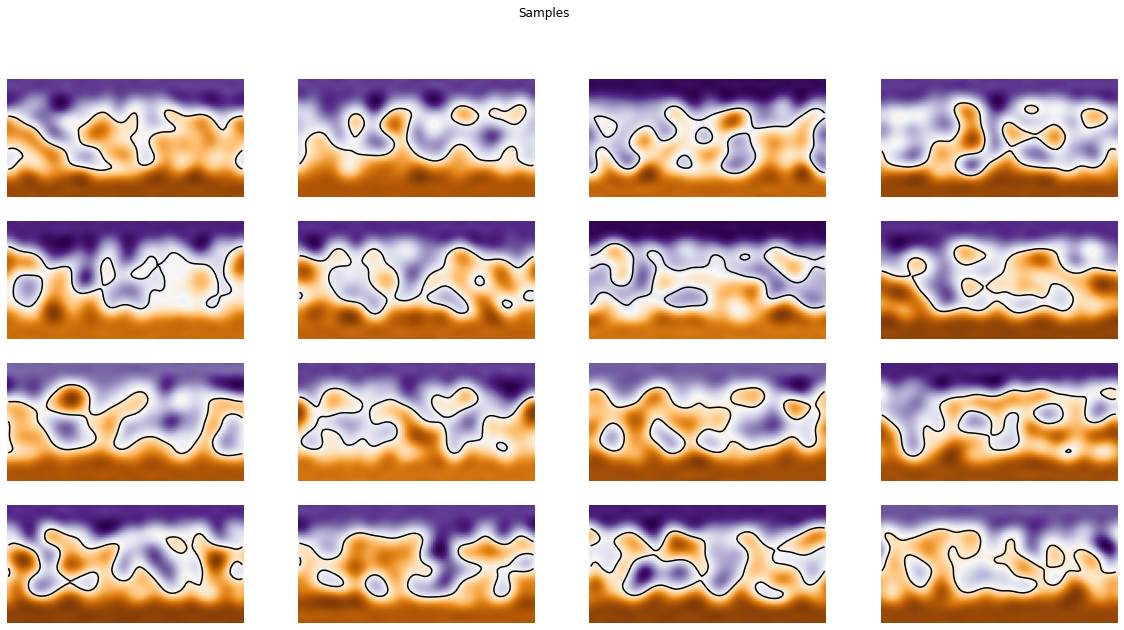

Number of accepted samples = 1107


In [3]:
samples = model.predict(x_test.to(device), num_samples=2000, need_plot=True)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

accepted_samples = []
for sample in samples:
    sample = (sample - sample.min()) / (sample.max() - sample.min()) * 2 - 1
    sign = sample > 0
    if (2 * sign - 1).sum() < 100:
        accepted_samples.append(sample)
samples = accepted_samples
print(f'Number of accepted samples = {len(samples)}')

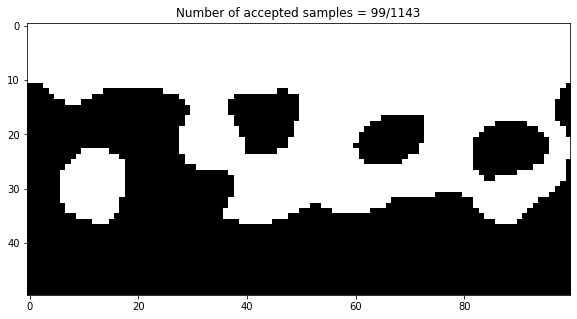

In [19]:
accepted_samples = []
for sample in samples:
    plt.figure(figsize=(20, 5))
    plt.title(f'Number of accepted samples = {len(accepted_samples)}/{len(samples)}')
    plt.imshow(sample > 0, cmap='gray')
    plt.show()
    choice = input('Accept? (3/*)')
    if choice == '3':
        accepted_samples.append(sample)
    if choice == 'q' or len(accepted_samples) == 100:
        break
    clear_output(wait=True)

In [28]:
torch.save(torch.stack(accepted_samples), './Tests/_FINAL/samples.pt')

In [25]:
# color every black point (value 0) to white (value 1) with probability p
def color_black_points(img, p):
    img = np.array(img)
    img[img == 0] = np.random.choice([0, 1], size=img[img == 0].shape, p=[1-p, p])
    return img

@interact(i=(0, len(samples)-1), p=(0, 1, 0.01))
def _(i, p=0.5):
    img = samples[i]
    original, _, _ = prepare_gpr_results(img, x_parts=5, scale_coef=0.85, color=0.1, need_plot=False)
    colored = color_black_points(original, p)
    # compute percentage of colored pixels
    black_pixels = (1-original).sum()
    new_black_pixels = (1-colored).sum()
    percent_of_colored = (black_pixels - new_black_pixels) / black_pixels * 100
    print(f'Percentage of colored pixels = {percent_of_colored:.2f}%')
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(colored, cmap='gray')
    plt.title(f'Colored with p = {p}')
    


interactive(children=(IntSlider(value=571, description='i', max=1142), FloatSlider(value=0.5, description='p',…

In [28]:
accepted = []
for i, sample in enumerate(samples):
    sample = (sample - sample.min()) / (sample.max() - sample.min()) * 2 - 1
    sign = sample > 0
    s = (2*sign-1).sum().abs()
    if s < 10:
        print(i)
        accepted.append(sample)

144
183
207
321
436
550
601
871
950
979
982
1048
1174
1188
1279
1484
1530
1560
1674
1716
1726
1870
1933
1977
2033
2131
2139
2236
2246
2327
2506
2594
2698
2732
2882
2968
3015
3041
3223
3224
3265
3343
3344
3385
3394
3863
4012
4130
4203
4479
4563
4604
4625
4827
5166
5504
5564
5633
5661
5699
6094
6212
6326
6424
6447
6464
6501
6518
6676
6687
6716
6906
6945
7077
7178
7343
7421
7453
7528
7576
7583
7635
7671
7705
7727
7775
7786
7843
8026
8403
8498
8589
8652
8696
8725
8993
9297
9310
9379
9489
9580
9596
9673
9699
9852
9962
10002
10054
10352
10371
10415
10515
10677
10801
10811
11046
11072
11096
11118
11120
11144
11161
11189
11431
11455
11500
11535
11989
12074
12217
12262
12264
12283
12556
12627
12652
12845
12965
13039
13156
13261
13319
13464
13523
13540
13547
13553
13611
13618
13672
13673
13714
13831
13920
13959
14031
14092
14114
14349
14426
14490
14497
14519
14566
14569
14730
14849
15247
15348
15356
15391
15468
15677
15868
16156
16359
16487
16523
16533
16593
16618
16684
16760
16798
17000
17082
1

In [23]:
from ipywidgets import interact

In [29]:
@interact(i=(0, len(accepted)-1))
def _(i=0):
    plt.figure(figsize=(20, 5))
    plt.imshow(accepted[i] > 0, cmap='gray')

interactive(children=(IntSlider(value=0, description='i', max=1134), Output()), _dom_classes=('widget-interact…

In [31]:
# make accepted as tensor
accepted = torch.stack(accepted)

In [33]:
accepted.shape

torch.Size([1135, 50, 100])

In [34]:
# save accepted
torch.save(accepted, 'accepted_samples.pt')

In [36]:
# load accepted
accepted = torch.load('accepted_samples.pt')
accepted.min(), accepted.max()

(tensor(-1.), tensor(1.))